<a href="https://colab.research.google.com/github/francescopatane96/Computer_aided_drug_discovery_kit/blob/main/8_protein_data_acquisition_from_PDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Protein data acquisition from PDB

In [4]:
from google.colab import output
output.enable_custom_widget_manager()

In [5]:
!pip install redo requests_cache nglview pypdb rdkit biotite

In [6]:
pip install biopython==1.77

In [7]:
pip install Bio==1.77

ERROR: Could not find a version that satisfies the requirement Bio==1.77 (from versions: 1.0.2, 1.2.0, 1.3.2, 1.3.3, 1.3.4, 1.3.5, 1.3.6, 1.3.7, 1.3.8, 1.3.9, 1.4.0, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 1.5.4, 1.5.5, 1.5.6, 1.5.7, 1.5.8, 1.5.9)
ERROR: No matching distribution found for Bio==1.77


In [8]:
!pip install https://github.com/volkamerlab/opencadd/archive/master.tar.gz

  Using cached https://github.com/volkamerlab/opencadd/archive/master.tar.gz
  Preparing metadata (setup.py) ... done


In [9]:
import collections
import logging
import pathlib
import time
import warnings
import datetime

import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from tqdm.auto import tqdm
import redo
import requests_cache
import nglview
import pypdb
import biotite.database.rcsb as rcsb
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

import opencadd

# Disable some unneeded warnings
logger = logging.getLogger("opencadd")
logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

# Cache requests -- this will speed up repeated queries to PDB
requests_cache.install_cache("rcsb_pdb", backend="memory")

In [10]:
uniprot_id = "P00533"

In [11]:
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
today = datetime.datetime.now()
print(
    f"Number of structures on {today.year}-{today.month}-{today.day}: {rcsb.count(query_by_uniprot_id)}"
)

Number of structures on 2023-8-13: 281


In [12]:
# Define lists for years and number of structures available in a given year
years = range(1971, datetime.datetime.now().year)
n_structures = []

for year in years:
    # Set latest date for allowed deposition
    before_deposition_date = f"{year}-12-31T23:59:59Z"
    # Set up query for structures deposited latest at given date
    query_by_deposition_date = rcsb.FieldQuery(
        "rcsb_accession_info.deposit_date", less_or_equal=before_deposition_date
    )
    # Set up combined query
    query = rcsb.CompositeQuery(
        [query_by_uniprot_id, query_by_deposition_date],
        "and",
    )
    # Count matching structures and add to list
    n_structures.append(rcsb.count(query))
    # wait shortly to not overload the API
    time.sleep(0.1)

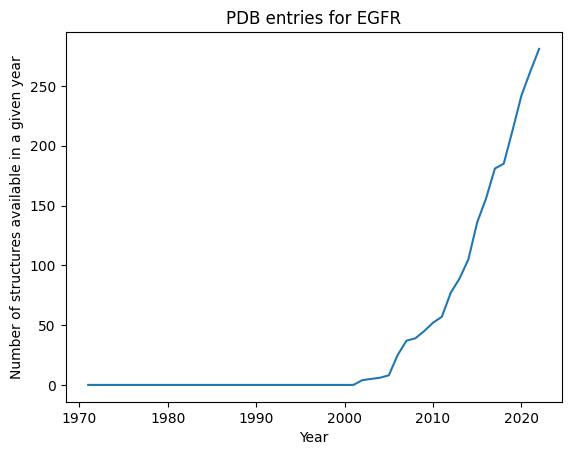

In [13]:
plt.plot(years, n_structures)
plt.title("PDB entries for EGFR")
plt.xlabel("Year")
plt.ylabel("Number of structures available in a given year");

In [14]:
uniprot_id = "P00533"
before_deposition_date = "2020-01-01T00:00:00Z"
experimental_method = "X-RAY DIFFRACTION"
max_resolution = 3.0
n_chains = 1
min_ligand_molecular_weight = 100.0

In [15]:
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
query_by_deposition_date = rcsb.FieldQuery(
    "rcsb_accession_info.deposit_date", less=before_deposition_date
)
query_by_experimental_method = rcsb.FieldQuery("exptl.method", exact_match=experimental_method)
query_by_resolution = rcsb.FieldQuery(
    "rcsb_entry_info.resolution_combined", less_or_equal=max_resolution
)
query_by_polymer_count = rcsb.FieldQuery(
    "rcsb_entry_info.deposited_polymer_entity_instance_count", equals=n_chains
)
query_by_ligand_mw = rcsb.FieldQuery(
    "chem_comp.formula_weight", molecular_definition=True, greater=min_ligand_molecular_weight
)

In [16]:
print(f"Number of structures with UniProt ID {uniprot_id}: {rcsb.count(query_by_uniprot_id)}")
time.sleep(0.1)  # wait shortly to not overload the API
print(
    f"Number of structures deposited before {before_deposition_date}: {rcsb.count(query_by_deposition_date)}"
)
time.sleep(0.1)
print(
    f"Number of structures resolved by {experimental_method}: {rcsb.count(query_by_experimental_method)}"
)
time.sleep(0.1)
print(
    f"Number of structures with resolution less than or equal to {max_resolution}: {rcsb.count(query_by_resolution)}"
)
time.sleep(0.1)
print(f"Number of structures with only {n_chains} chain: {rcsb.count(query_by_polymer_count)}")
time.sleep(0.1)
print(
    f"Number of structures with ligand of more than or equal to {min_ligand_molecular_weight} Da: {rcsb.count(query_by_ligand_mw)}"
)

Number of structures with UniProt ID P00533: 281
Number of structures deposited before 2020-01-01T00:00:00Z: 166261
Number of structures resolved by X-RAY DIFFRACTION: 177521
Number of structures with resolution less than or equal to 3.0: 170190
Number of structures with only 1 chain: 75451
Number of structures with ligand of more than or equal to 100.0 Da: 208346


In [17]:
query = rcsb.CompositeQuery(
    [
        query_by_uniprot_id,
        query_by_deposition_date,
        query_by_experimental_method,
        query_by_resolution,
        query_by_polymer_count,
        query_by_ligand_mw,
    ],
    "and",
)
pdb_ids = rcsb.search(query)
print(f"Number of matches: {len(pdb_ids)}")
print("Selected PDB IDs:")
print(*pdb_ids)

Number of matches: 110
Selected PDB IDs:
1M14 1M17 1XKK 2EB2 2EB3 2GS2 2ITN 2ITP 2ITQ 2ITT 2ITU 2ITV 2ITW 2ITX 2ITZ 2J5F 2RGP 3BEL 3GOP 3POZ 3UG1 3UG2 3VJN 3VJO 3W2O 3W2P 3W2Q 3W2R 3W2S 3W32 3W33 4G5J 4HJO 4I1Z 4I22 4I23 4JQ7 4JQ8 4JR3 4JRV 4LI5 4LQM 4RJ4 4RJ6 4RJ7 4RJ8 4WKQ 4WRG 4ZAU 5C8K 5C8M 5C8N 5CAL 5CAN 5CAO 5CAP 5CAQ 5CAS 5CAU 5CAV 5EDP 5EDQ 5EDR 5EM5 5EM6 5EM7 5EM8 5FED 5FEE 5GMP 5GNK 5GTZ 5HCX 5HCY 5HCZ 5HG5 5HG7 5HG8 5HG9 5HIB 5HIC 5J9Y 5J9Z 5U8L 5UG8 5UG9 5UGA 5UGB 5UGC 5X26 5X27 5X28 5XDK 5XDL 5XGM 5ZTO 5ZWJ 6D8E 6JRJ 6JRK 6JRX 6JWL 6JX0 6JX4 6JXT 6JZ0 6S89 6S8A 6S9C 6S9D


In [18]:
@redo.retriable(attempts=10, sleeptime=2)
def describe_one_pdb_id(pdb_id):
    """Fetch meta information from PDB."""
    described = pypdb.describe_pdb(pdb_id)
    if described is None:
        print(f"! Error while fetching {pdb_id}, retrying ...")
        raise ValueError(f"Could not fetch PDB id {pdb_id}")
    return described

In [19]:
pdbs_data = [describe_one_pdb_id(pdb_id) for pdb_id in tqdm(pdb_ids)]

  0%|          | 0/110 [00:00<?, ?it/s]

In [20]:
print("\n".join(pdbs_data[0].keys()))

audit_author
cell
citation
diffrn
diffrn_detector
diffrn_radiation
diffrn_source
entry
exptl
exptl_crystal
exptl_crystal_grow
pdbx_audit_revision_details
pdbx_audit_revision_group
pdbx_audit_revision_history
pdbx_database_related
pdbx_database_status
rcsb_accession_info
rcsb_entry_container_identifiers
rcsb_entry_info
rcsb_primary_citation
refine
refine_analyze
refine_hist
refine_ls_restr
reflns
reflns_shell
software
struct
struct_keywords
symmetry
rcsb_id


In [21]:
pdbs_data[0]["entry"]

{'id': '1M14'}

In [76]:
pdbs_data[0]["rcsb_entry_info"]

{'assembly_count': 1,
 'branched_entity_count': 0,
 'cis_peptide_count': 0,
 'deposited_atom_count': 2469,
 'deposited_hydrogen_atom_count': 0,
 'deposited_model_count': 1,
 'deposited_modeled_polymer_monomer_count': 307,
 'deposited_nonpolymer_entity_instance_count': 0,
 'deposited_polymer_entity_instance_count': 1,
 'deposited_polymer_monomer_count': 333,
 'deposited_solvent_atom_count': 17,
 'deposited_unmodeled_polymer_monomer_count': 26,
 'diffrn_radiation_wavelength_maximum': 1.008,
 'diffrn_radiation_wavelength_minimum': 1.008,
 'disulfide_bond_count': 0,
 'entity_count': 2,
 'experimental_method': 'X-ray',
 'experimental_method_count': 1,
 'inter_mol_covalent_bond_count': 0,
 'inter_mol_metalic_bond_count': 0,
 'molecular_weight': 37.88,
 'na_polymer_entity_types': 'Other',
 'nonpolymer_entity_count': 0,
 'polymer_composition': 'homomeric protein',
 'polymer_entity_count': 1,
 'polymer_entity_count_dna': 0,
 'polymer_entity_count_rna': 0,
 'polymer_entity_count_nucleic_acid': 0

In [77]:
resolution = pd.DataFrame(
    [
        [pdb_data["entry"]["id"], pdb_data["rcsb_entry_info"]["resolution_combined"][0]]
        for pdb_data in pdbs_data
    ],
    columns=["pdb_id", "resolution"],
).sort_values(by="resolution", ignore_index=True)
resolution

,pdb_id,resolution
0,5UG9,1.330
1,5HG8,1.420
2,5UG8,1.460
3,3POZ,1.500
4,5HG5,1.520
...,...,...
105,2ITX,2.980
106,5GTZ,2.999
107,2J5F,3.000
108,4I1Z,3.000


In [78]:
top_num = 6  # Number of top structures

In [79]:
selected_pdb_ids = resolution[:top_num]["pdb_id"].to_list()
print(f"Selected PDB IDs: {selected_pdb_ids}")

Selected PDB IDs: ['5UG9', '5HG8', '5UG8', '3POZ', '5HG5', '5UGC']


In [80]:
selected_pdb_ids = ["5UG9", "5HG8", "5UG8", "5UGC"]
print(f"Selected PDB IDs (frozen set): {selected_pdb_ids}")

Selected PDB IDs (frozen set): ['5UG9', '5HG8', '5UG8', '5UGC']


In [81]:
def get_ligands(pdb_id):
    """
    RCSB has not provided a new endpoint for ligand information yet. As a
    workaround we are obtaining extra information from ligand-expo.rcsb.org,
    using HTML parsing. Check Talktorial T011 for more info on this technique!
    """
    pdb_info = _fetch_pdb_nonpolymer_info(pdb_id)
    ligand_expo_ids = [
        nonpolymer_entities["pdbx_entity_nonpoly"]["comp_id"]
        for nonpolymer_entities in pdb_info["data"]["entry"]["nonpolymer_entities"]
    ]

    ligands = {}
    for ligand_expo_id in ligand_expo_ids:
        ligand_expo_info = _fetch_ligand_expo_info(ligand_expo_id)
        ligands[ligand_expo_id] = ligand_expo_info

    return ligands


def _fetch_pdb_nonpolymer_info(pdb_id):
    """
    Fetch nonpolymer data from rcsb.org.
    Thanks @BJWiley233 and Rachel Green for this GraphQL solution.
    """
    query = (
        """{
          entry(entry_id: "%s") {
            nonpolymer_entities {
              pdbx_entity_nonpoly {
                comp_id
                name
                rcsb_prd_id
              }
            }
          }
        }"""
        % pdb_id
    )

    query_url = f"https://data.rcsb.org/graphql?query={query}"
    response = requests.get(query_url)
    response.raise_for_status()
    info = response.json()
    return info


def _fetch_ligand_expo_info(ligand_expo_id):
    """
    Fetch ligand data from ligand-expo.rcsb.org.
    """
    r = requests.get(f"http://ligand-expo.rcsb.org/reports/{ligand_expo_id[0]}/{ligand_expo_id}/")
    r.raise_for_status()
    html = BeautifulSoup(r.text)
    info = {}
    for table in html.find_all("table"):
        for row in table.find_all("tr"):
            cells = row.find_all("td")
            if len(cells) != 2:
                continue
            key, value = cells
            if key.string and key.string.strip():
                info[key.string.strip()] = "".join(value.find_all(string=True))

    # Postprocess some known values
    info["Molecular weight"] = float(info["Molecular weight"].split()[0])
    info["Formal charge"] = int(info["Formal charge"])
    info["Atom count"] = int(info["Atom count"])
    info["Chiral atom count"] = int(info["Chiral atom count"])
    info["Bond count"] = int(info["Bond count"])
    info["Aromatic bond count"] = int(info["Aromatic bond count"])
    return info

In [82]:
columns = [
    "@structureId",
    "@chemicalID",
    "@type",
    "@molecularWeight",
    "chemicalName",
    "formula",
    "InChI",
    "InChIKey",
    "smiles",
]
rows = []
for pdb_id in selected_pdb_ids:
    ligands = get_ligands(pdb_id)
    # If several ligands contained, take largest (first in results)
    ligand_id, properties = max(ligands.items(), key=lambda kv: kv[1]["Molecular weight"])
    rows.append(
        [
            pdb_id,
            ligand_id,
            properties["Component type"],
            properties["Molecular weight"],
            properties["Name"],
            properties["Formula"],
            properties["InChI descriptor"],
            properties["InChIKey descriptor"],
            properties["Stereo SMILES (OpenEye)"],
        ]
    )

In [83]:
# NBVAL_CHECK_OUTPUT
# Change the format to DataFrame
ligands = pd.DataFrame(rows, columns=columns)
ligands

,@structureId,@chemicalID,@type,@molecularWeight,chemicalName,formula,InChI,InChIKey,smiles
0,5UG9,8AM,NON-POLYMER,445.494,"N-[(3R,4R)-4-fluoro-1-{6-[(3-methoxy-1-methyl-...",C20 H28 F N9 O2,InChI=1S/C20H28FN9O2/c1-6-15(31)23-13-9-29(7-1...,MJLFLAORJNTNDV-CHWSQXEVSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...
1,5HG8,634,NON-POLYMER,377.400,N-[3-({2-[(1-methyl-1H-pyrazol-4-yl)amino]-7H-...,C19 H19 N7 O2,InChI=1S/C19H19N7O2/c1-3-16(27)22-12-5-4-6-14(...,YWNHZBNRKJYHTR-UHFFFAOYSA-N,CCC(=O)Nc1cccc(c1)Oc2c3cc[nH]c3nc(n2)Nc4cnn(c4)C
2,5UG8,8BP,NON-POLYMER,415.468,"N-[(3R,4R)-4-fluoro-1-{6-[(1-methyl-1H-pyrazol...",C19 H26 F N9 O,InChI=1S/C19H26FN9O/c1-5-15(30)24-14-9-28(8-13...,CGULPICMFDDQRH-ZIAGYGMSSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...
3,5UGC,8BS,NON-POLYMER,417.441,"N-[(3R,4R)-4-fluoro-1-{6-[(3-methoxy-1-methyl-...",C18 H24 F N9 O2,InChI=1S/C18H24FN9O2/c1-5-13(29)21-11-8-28(6-1...,XWNKXCUQRQRAFF-GHMZBOCLSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...


In [84]:
ligands.to_csv("PDB_top_ligands.csv", header=True, index=False)

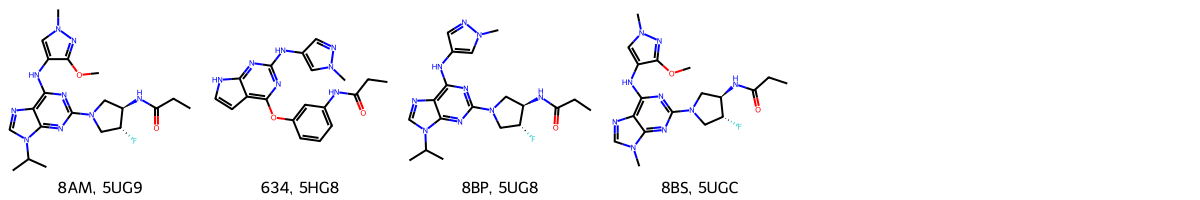

In [85]:
PandasTools.AddMoleculeColumnToFrame(ligands, "smiles")
Draw.MolsToGridImage(
    mols=list(ligands.ROMol),
    legends=list(ligands["@chemicalID"] + ", " + ligands["@structureId"]),
    molsPerRow=top_num,
)

In [86]:
# NBVAL_CHECK_OUTPUT
pairs = collections.OrderedDict(zip(ligands["@structureId"], ligands["@chemicalID"]))
pairs

OrderedDict([('5UG9', '8AM'),
             ('5HG8', '634'),
             ('5UG8', '8BP'),
             ('5UGC', '8BS')])

In [33]:
pip install mdanalysis

  Using cached biopython-1.81-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Attempting uninstall: biopython
    Found existing installation: biopython 1.77
    Uninstalling biopython-1.77:
      Successfully uninstalled biopython-1.77


In [34]:
from opencadd.structure.core import Structure

In [87]:
# Download PDB structures
structures = [Structure.from_pdbid(pdb_id) for pdb_id in pairs]
structures

[<Universe with 2664 atoms>,
 <Universe with 2716 atoms>,
 <Universe with 2632 atoms>,
 <Universe with 2542 atoms>]

In [88]:
complexes = [
    Structure.from_atomgroup(structure.select_atoms(f"protein or resname {ligand}"))
    for structure, ligand in zip(structures, pairs.values())
]
complexes

[<Universe with 2330 atoms>,
 <Universe with 2491 atoms>,
 <Universe with 2319 atoms>,
 <Universe with 2320 atoms>]

In [89]:
# Write complex to file
for complex_, pdb_id in zip(complexes, pairs.keys()):
    complex_.write(f"{pdb_id}.pdb")

In [38]:
from opencadd.structure.superposition.api import align, METHODS


In [39]:
pip install biopython==1.77


  Using cached biopython-1.77-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: biopython
    Found existing installation: biopython 1.81
    Uninstalling biopython-1.81:
      Successfully uninstalled biopython-1.81
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mdanalysis 2.5.0 requires biopython>=1.80, but you have biopython 1.77 which is incompatible.
bio 1.5.9 requires biopython>=1.80, but you have biopython 1.77 which is incompatible.


In [40]:
import Bio; print(Bio.__version__)

1.77


In [90]:
results = align(complexes, method=METHODS["mda"])

AttributeError: ignored

In [91]:
ligands = [
    Structure.from_atomgroup(complex_.select_atoms(f"resname {ligand}"))
    for complex_, ligand in zip(complexes, pairs.values())
]
ligands

[<Universe with 32 atoms>,
 <Universe with 28 atoms>,
 <Universe with 30 atoms>,
 <Universe with 30 atoms>]

In [92]:
from pathlib import Path

In [103]:
# Define paths
HERE = pathlib.Path(_dh[-1])
DATA = HERE / "data"

In [104]:
for ligand, pdb_id in zip(ligands, pairs.keys()):
    ligand.write(DATA / f"{pdb_id}_lig.pdb")

In [53]:
ligand_files = []
for file in "*_lig.pdb":
    ligand_files.append(file)
ligand_files

['*', '_', 'l', 'i', 'g', '.', 'p', 'd', 'b']

In [49]:
view = nglview.NGLWidget()
for component_id, ligand in enumerate(ligands):
    view.add_component(ligand.atoms)
    view.remove_ball_and_stick(component=component_id)
    view.add_licorice(component=component_id)
view

NGLWidget()

In [50]:
view.render_image(trim=True, factor=2, transparent=True);

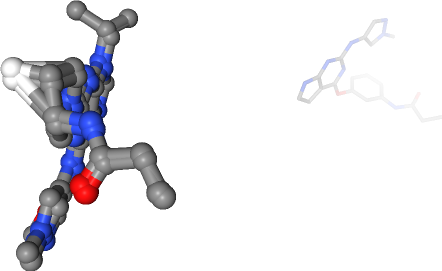

In [51]:
view._display_image()